In [22]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

# CSV files

DIR_PATH = "/kaggle/input/facial-keypoints-detection/"
training_data = pd.read_csv(f"{DIR_PATH}training.zip")
test_data = pd.read_csv(f"{DIR_PATH}test.zip")
id_lookup_table = pd.read_csv(f"{DIR_PATH}IdLookupTable.csv")

# Params
BATCH_SIZE = 128
VALID_SIZE = 0.2
N_EPOCHS = 50

In [12]:
# Data 

class FacialKeypointsDataset(Dataset):
    
    def __init__(self, dataset, train=True, transform=None):
        self.dataset = dataset.fillna(method = "ffill")
        self.train = train
        self.transform = transform

    def get_image(self, idx):
        image = np.fromstring(self.dataset.iloc[idx, -1], sep=' ')
        image = image.astype(np.float32)
        image = image.reshape(96, 96, 1) 
        return image
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):        
        if self.train:
            keypoints = self.dataset.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None

        sample = {'image': self.get_image(idx), 'keypoints': keypoints}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


def prepare_dataloaders(dataset, valid_size=0.2, batch_size=128):
    dataset_len = len(dataset)
    dataset_indices = list(range(dataset_len))
    np.random.shuffle(dataset_indices)
    split = int(np.floor(valid_size * dataset_len))
    train_idx, valid_idx = dataset_indices[split:], dataset_indices[:split]
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
    valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))
    
    return train_loader, valid_loader

# Transforms

class Normalize(object):    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., 'keypoints': keypoints}
        
class ToTensor(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # NumPy image: H x W x C versus Torch image: C X H X W
        image = image.reshape(1, 96, 96)
        
        if keypoints is not None:
            return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(keypoints)}
        else:
            return {'image': torch.from_numpy(image)}

# Utilities

def create_submission(predictions, id_lookup_table=id_lookup_table):
    features_n = list(id_lookup_table['FeatureName'])
    img_ids = list(id_lookup_table['ImageId']-1) 

    features_lst = [features_n.index(feature) for feature in features_n]

    submission = pd.DataFrame({
        "RowId": list(id_lookup_table['RowId']),
        "Location": [predictions[x][y] for x, y in zip(img_ids, features_lst)]
    })
    submission.to_csv("submission.csv",index = False)
    

def show_image(image, training_key_points, test_key_points= None):
    plt.imshow(image, cmap="gray")

    training_key_points = training_key_points.reshape([15, 2])
    plt.plot(training_key_points[:,0], training_key_points[:,1], 'gx')
    
    if len(test_key_points) > 0:
        test_key_points = test_key_points.reshape([15, 2])
        plt.plot(test_key_points[:,0], test_key_points[:,1], 'rx')
        
        
def plot_RMSE(train_losses, valid_losses, y_max=50):
    plt.plot(train_losses, "--", linewidth=3, label="train")
    plt.plot(valid_losses, linewidth=3, label="val")
    plt.legend()
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.ylim((0, y_max))
    plt.show()

In [19]:
# Models 

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        super(MLP, self).__init__()
        
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) 
                                            for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [14]:
transformations = transforms.Compose([Normalize(), ToTensor()])

trainset = FacialKeypointsDataset(training_data, transform=transformations)
testset = FacialKeypointsDataset(test_data, train=False, transform=transformations)

train_loader, valid_loader = prepare_dataloaders(trainset, valid_size=VALID_SIZE, batch_size=BATCH_SIZE)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE)

In [21]:
model = MLP(input_size=96*96, output_size=30, hidden_layers=[128, 64], drop_p=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    train_loss = 0.0
    valid_loss = 0.0

    model.train() 
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch['image'].to(device))
        loss = criterion(output, batch['keypoints'].to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch['image'].size(0)

    model.eval() 
    for batch in valid_loader:
        output = model(batch['image'].to(device))
        loss = criterion(output, batch['keypoints'].to(device))
        valid_loss += loss.item()*batch['image'].size(0)

    train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
    valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))


Epoch: 1 	Training Loss: 23.298031 	Validation Loss: 12.390262
Epoch: 2 	Training Loss: 13.627992 	Validation Loss: 11.648537
Epoch: 3 	Training Loss: 12.631927 	Validation Loss: 10.872093
Epoch: 4 	Training Loss: 11.995429 	Validation Loss: 10.476156
Epoch: 5 	Training Loss: 11.603543 	Validation Loss: 11.649206
Epoch: 6 	Training Loss: 11.691733 	Validation Loss: 11.976107
Epoch: 7 	Training Loss: 11.290816 	Validation Loss: 10.723141
Epoch: 8 	Training Loss: 11.322264 	Validation Loss: 10.347157
Epoch: 9 	Training Loss: 10.782571 	Validation Loss: 12.771586
Epoch: 10 	Training Loss: 10.991423 	Validation Loss: 9.718294
Epoch: 11 	Training Loss: 10.800525 	Validation Loss: 10.281125
Epoch: 12 	Training Loss: 10.748384 	Validation Loss: 9.616045
Epoch: 13 	Training Loss: 10.523871 	Validation Loss: 9.370790
Epoch: 14 	Training Loss: 10.573481 	Validation Loss: 10.938303
Epoch: 15 	Training Loss: 10.541088 	Validation Loss: 9.476543
Epoch: 16 	Training Loss: 10.182258 	Validation Loss:

In [ ]:
plot_RMSE(train_losses, valid_losses, y_max=40)

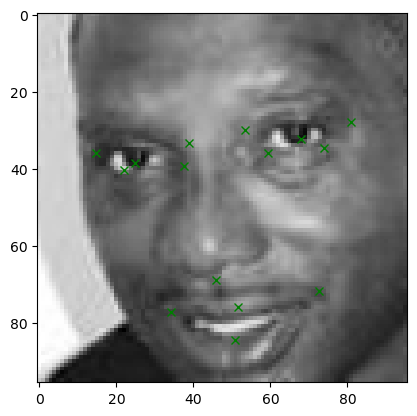

In [91]:
show_image(image=x_train[2], training_key_points=y_train[2])

In [94]:
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        output = model(batch['image'].to(device)).cpu().numpy()
        if i == 0:
            predictions = output
        else:
            predictions = np.vstack((predictions, output))
    

create_submission(predictions)

56/56 [==============================] - 15s 263ms/step


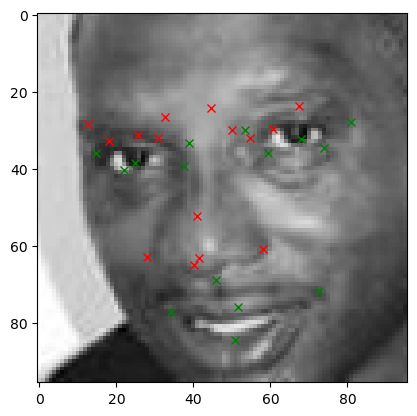

In [97]:
show_image(image=x_train[2], training_key_points=y_train[2], test_key_points=predictions[2])